<a href="https://colab.research.google.com/github/ziatdinovmax/AtomicImageSimulator/blob/master/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training deep learning model in PyTorch for "semantic" segmentation of atomic images

Prepared by Maxim Ziatdinov

This notebook demonstrates how to train a simple fully convolutional neural network for a multi-class "semantic" segmentation of atomic images. We are going to use a training set [made of synthetic atomic images](https://colab.research.google.com/github/ziatdinovmax/AtomicImageSimulator/blob/master/GenerateTrainingSet.ipynb).

Imports:

In [0]:
# Import modules
import os
import numpy as np
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
# Reproducibility
np.random.seed(1)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

Load training data. Here we use data prepared using [this notebook](https://colab.research.google.com/github/ziatdinovmax/AtomicImageSimulator/blob/master/GenerateTrainingSet.ipynb) (if you have your training data stored on a Google drive, mount your drive first or use a ```gdown``` command to download it from your drive into the notebook).

In [0]:
datadir = './' # adjust accordingly
images_all = np.load(datadir + 'Hex-X_train.npy')
labels_all = np.load(datadir + 'Hex-y_train.npy')
images_all_test = np.load(datadir + 'Hex-X_test.npy')
labels_all_test = np.load(datadir + 'Hex-y_test.npy')

We will construct a very simple encoder-decoder type of fully convolutional neural network. It will three main building blocks: block of convolutional layers activated by ReLU function, max-pooling, and upsampling block. Below we define convolutional and upsampling blocks.

In [0]:
class conv2dblock(nn.Module):
    '''
    Creates a block consisting of convolutional
    layer, leaky relu and (optionally) dropout and
    batch normalization
    '''
    def __init__(self, nb_layers, input_channels, output_channels,
                 kernel_size=3, stride=1, padding=1, use_batchnorm=True,
                 lrelu_a=0.01, dropout_=0):
        '''Initializes module parameters'''
        super(conv2dblock, self).__init__()
        block = []
        for idx in range(nb_layers):
            input_channels = output_channels if idx > 0 else input_channels
            block.append(nn.Conv2d(input_channels,
                                   output_channels,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=padding))
            if dropout_ > 0:
                block.append(nn.Dropout(dropout_))
            block.append(nn.LeakyReLU(negative_slope=lrelu_a))
            if use_batchnorm:
                block.append(nn.BatchNorm2d(output_channels))
        self.block = nn.Sequential(*block)

    def forward(self, x):
        '''Forward path'''
        output = self.block(x)
        return output


class upsample_block(nn.Module):
    '''
    Defines upsampling block performed using
    bilinear interpolation followed by 1-by-1
    convolution (the latter can be used to decrease 
    a number of channels at no cost)
    '''
    def __init__(self, input_channels, output_channels,
                 mode='interpolate', kernel_size=1,
                 stride=1, padding=0):
        '''Initalizes model parameters'''
        super(upsample_block, self).__init__()
        self.conv = nn.Conv2d(
            input_channels, output_channels,
            kernel_size=kernel_size,
            stride=stride, padding=padding)

    def forward(self, x):
        '''Defines a forward path'''
        x = F.interpolate(
            x, scale_factor=2,
            mode='bilinear', align_corners=False)
        return self.conv(x) 

We now construct our neural network. Notice that we are using an object-oriented way of defining our neural network as it gives more flexibility. For example, we can easily modify the code below to add skip connections between contracting and expanding paths, which is not possible to do if we define our neural network using 'Sequential' module.

In [0]:
class atomnet(nn.Module):
    def __init__(self, nb_classes=3, nb_filters=25): 
        '''
        Builds  a fully convolutional neural network model
        (encoder-bottleneck-decoder type of architecture)
        Args:
            nb_classes: number of classes in the data
            nb_filters: number of filters in the first convolutional layer
        '''
        super(atomnet, self).__init__()
        self.pxac = 'softmax' if nb_classes > 1 else 'sigmoid'
        self.c1 = conv2dblock(1, 1, nb_filters)
        self.c2 = conv2dblock(2, nb_filters, 2*nb_filters)
        self.c3 = conv2dblock(3, 2*nb_filters, 4*nb_filters)
        self.bn = conv2dblock(4, 4*nb_filters, 8*nb_filters)
        self.up1 = upsample_block(8*nb_filters, 8*nb_filters)
        self.c4 = conv2dblock(3, 8*nb_filters, 4*nb_filters)
        self.up2 = upsample_block(4*nb_filters, 4*nb_filters)
        self.c5 = conv2dblock(2, 4*nb_filters, 2*nb_filters)
        self.up3 = upsample_block(2*nb_filters, 2*nb_filters)
        self.c6 = conv2dblock(1, 2*nb_filters, nb_filters)
        self.px = nn.Conv2d(nb_filters, nb_classes, 1, 1, 0)
               
    def forward(self, x):
        '''Forward path'''
        # Contracting path
        c1 = self.c1(x)
        d1 = F.max_pool2d(c1, 2, 2)
        c2 = self.c2(d1)
        d2 = F.max_pool2d(c2, 2, 2)
        c3 = self.c3(d2)
        d3 = F.max_pool2d(c3, 2, 2)
        # Bottleneck layer
        bn = self.bn(d3)
        # Expanding path
        u1 = self.up1(bn)
        u1 = self.c4(u1)
        u2 = self.up2(u1)
        u2 = self.c5(u2)
        u3 = self.up3(u2)
        u3 = self.c6(u3)
        px = self.px(u3)
        if self.pxac == 'sigmoid':
            out = torch.sigmoid(px)
        elif self.pxac == 'softmax':
            out = F.log_softmax(px, dim=1)
        return out

Next we initalize our model and move it to GPU. We also define a loss function and a weight optimizer. Notice that for multiclass sematic segmentation problems, the input batch with images has ```(n_samples, 1, height, width)``` dimensions and the neural network output has```(n_samples, n_classes, height, width)``` dimensions. However, the batch with labels (aka target aka ground truth) has ```(n_samples, height, width)``` dimensions, because of how the cross-entropy loss is calculated in PyTorch (see [here](https://pytorch.org/docs/stable/nn.html#nllloss)). This means that if you have multiple channels corresponding to different classes in your labeled data, you'll need to [map your target classes to tensor indices](https://discuss.pytorch.org/t/multi-class-cross-entropy-loss-function-implementation-in-pytorch/19077/20). Here, we already did this for our labeled data [during the training data preparation stage](https://colab.research.google.com/github/ziatdinovmax/AtomicImageSimulator/blob/master/GenerateTrainingSet.ipynb) and so everything is ready for training.

In [0]:
# Initialize a model
model = atomnet(nb_filters=16)
# move our model to GPU
model.cuda()
# specify loss function
criterion = torch.nn.NLLLoss()
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Finally, we train our model:

In [7]:
batch_size = 32 # number of images in one batch
epochs = 1000 # Number of epochs (here 1 epoch == 1 batch)
print_loss = 100 # print loss every m-th epoch.
savedir = './' # dir to save results

# Generate sequence of random numbers for batch selection during training/testing
batch_ridx = [np.random.randint(0, len(images_all)) for _ in range(epochs)]
batch_ridx_t = [np.random.randint(0, len(images_all_test)) for _ in range(epochs)]
# Start training
train_losses, test_losses = [], []
for e in range(epochs):  
    model.train()
    running_loss = 0
    # Generate batch of training images with corresponding ground truth
    images = images_all[batch_ridx[e]][:batch_size]
    labels = labels_all[batch_ridx[e]][:batch_size]
    # Transform images and ground truth to torch tensors and move to GPU
    images = torch.from_numpy(images).float()
    labels = torch.from_numpy(labels).long()
    images, labels = images.cuda(), labels.cuda() 
    # Forward --> Backward --> Optimize
    optimizer.zero_grad() 
    prob = model.forward(images)
    loss = criterion(prob, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    # Now test the current model state using test data
    model.eval()
    batch_num = np.random.randint(0, len(images_all_test))
    images_ = images_all_test[batch_ridx_t[e]][:batch_size]
    labels_ = labels_all_test[batch_ridx_t[e]][:batch_size]
    images_ = torch.from_numpy(images_).float()
    labels_ = torch.from_numpy(labels_).long()
    images_, labels_ = images_.cuda(), labels_.cuda() 
    prob = model.forward(images_)
    loss = criterion(prob, labels_)
    test_losses.append(loss.item())
    # Print statistics
    if e == 0 or (e+1) % print_loss == 0:
        print('Epoch {} .... Training loss: {} .... Test loss: {}'.format(
            e+1, np.around(train_losses[-1], 8), np.around(test_losses[-1], 8))
        )
    # Save the best model weights
    if e > 100 and test_losses[-1] < min(test_losses[: -1]):
        torch.save(model.state_dict(), 
                   os.path.join(savedir, 'atomsegnet-1-best_weights.pt'))
# Save final weights
torch.save(model.state_dict(), 
           os.path.join(savedir, 'atomsegnet-1-final_weights.pt'))

Epoch 1 .... Training loss: 1.17794156 .... Test loss: 1.1115427
Epoch 100 .... Training loss: 0.453215 .... Test loss: 0.41167343
Epoch 200 .... Training loss: 0.17777865 .... Test loss: 0.18042941
Epoch 300 .... Training loss: 0.11185776 .... Test loss: 0.12554188
Epoch 400 .... Training loss: 0.08373596 .... Test loss: 0.08044664
Epoch 500 .... Training loss: 0.08613965 .... Test loss: 0.08184011
Epoch 600 .... Training loss: 0.07681989 .... Test loss: 0.07823607
Epoch 700 .... Training loss: 0.06573252 .... Test loss: 0.07035903
Epoch 800 .... Training loss: 0.06697897 .... Test loss: 0.07236966
Epoch 900 .... Training loss: 0.06651906 .... Test loss: 0.05881577
Epoch 1000 .... Training loss: 0.0674694 .... Test loss: 0.07857618


Plot train and test losses:

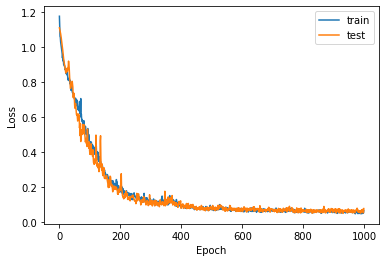

In [8]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Evaluate model performance on the test data:

Text(0.5, 1.0, 'Model prediction (class 2)')

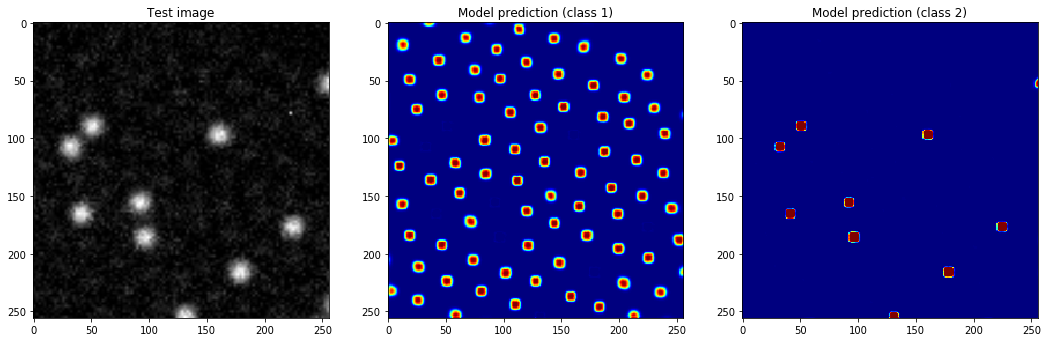

In [9]:
k, im = 2, 8 # batch, image
test_img = images_all_test[k][im]
# Convert to 4D tensor (required, even if it is a single image)
test_img = test_img[np.newaxis, ...]
# Convert to pytorch format
test_img_ = torch.from_numpy(test_img).float().cuda()
# make a prediction
prediction = model.forward(test_img_)
prediction = torch.exp(prediction).cpu().detach().numpy() # that's because we used log_softmax
# plot results
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(test_img[0,0], cmap='gray')
ax2.imshow(prediction[0,0], cmap='jet')
ax3.imshow(prediction[0,1], cmap='jet')
ax1.set_title('Test image')
ax2.set_title('Model prediction (class 1)')
ax3.set_title('Model prediction (class 2)')

We now have a multichannel output of a neural network where each channel corresponds to a different atomic class (+ background). In each channel, we have a set of blobs on a uniform background whose centers correspond to atomic centers (if the network was trained properly). What we have to do now is to convert pixel data from the network output into coordinate data. Below we define a class that will do it.

In [0]:
class FindAtoms:
    '''
    Transforms pixel data from NN output into coordinate data
    '''
    def __init__(self, nn_output,
                 threshold=0.5, dist_edge=5,
                 dim_order='channel_first'):
        
        if nn_output.shape[-1] == 1: # Add background class for 1-channel data
            nn_output_b = 1 - nn_output
            nn_output = np.concatenate(
                (nn_output[:, :, :, None], nn_output[:, :, :, None]), axis=3)
        if dim_order == 'channel_first':  # make channel dim the last dim
            nn_output = np.transpose(nn_output, (0, 2, 3, 1))
        elif dim_order == 'channel_last':
            pass
        else:
            raise NotImplementedError(
                'For dim_order, use "channel_first" (e.g. pytorch)',
                 'or "channel_last" (e.g. tensorflow)')
        self.nn_output = nn_output
        self.threshold = threshold
        self.dist_edge = dist_edge
                       
    def get_all_coordinates(self):
        '''Extract all atomic coordinates in image
        via CoM method & store data as a dictionary
        (key: frame number)'''
        
        def find_com(image_data):
            '''Find atoms via center of mass methods'''
            labels, nlabels = ndimage.label(image_data)
            coordinates = np.array(
                ndimage.center_of_mass(
                    image_data, labels, np.arange(nlabels) + 1))
            coordinates = coordinates.reshape(coordinates.shape[0], 2)
            return coordinates

        d_coord = {}
        for i, decoded_img in enumerate(self.nn_output):
            coordinates = np.empty((0, 2))
            category = np.empty((0, 1))
            # we assume that class backgrpund is always the last one
            for ch in range(decoded_img.shape[2]-1):
                _, decoded_img_c = cv2.threshold(
                    decoded_img[:, :, ch], self.threshold, 1, cv2.THRESH_BINARY)
                coord = find_com(decoded_img_c)
                coord_ch = self.rem_edge_coord(coord)
                category_ch = np.zeros((coord_ch.shape[0], 1)) + ch
                coordinates = np.append(coordinates, coord_ch, axis=0)
                category = np.append(category, category_ch, axis=0)
            d_coord[i] = np.concatenate((coordinates, category), axis=1)
        return d_coord

    def rem_edge_coord(self, coordinates):
        '''Remove coordinates at the image edges'''

        def coord_edges(coordinates, w, h):
            return [coordinates[0] > w - self.dist_edge,
                    coordinates[0] < self.dist_edge,
                    coordinates[1] > h - self.dist_edge,
                    coordinates[1] < self.dist_edge]

        w, h = self.nn_output.shape[1:3]
        coord_to_rem = [
                        idx for idx, c in enumerate(coordinates) 
                        if any(coord_edges(c, w, h))
                        ]
        coord_to_rem = np.array(coord_to_rem, dtype=int)
        coordinates = np.delete(coordinates, coord_to_rem, axis=0)
        return coordinates

Let's now transform our NN prediction on a test image to coordinates:

In [0]:
coordinates_im = FindAtoms(prediction).get_all_coordinates()

Plot results:

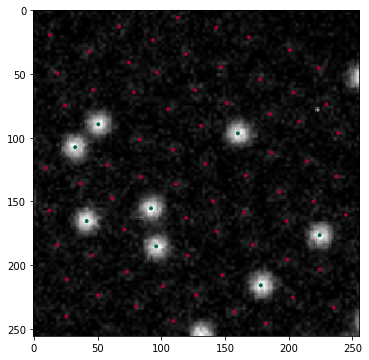

In [33]:
y, x, c = coordinates_im[0].T
plt.figure(figsize=(6, 6))
plt.imshow(test_img[0,0], cmap='gray')
plt.scatter(x, y, c=c, cmap='RdYlGn', s=8);